# Census of Immune Cells: Single-Cell Workflow with CoGAPS

# Authors
Tom Sherman - <tomsherman159@gmail.com>  
Ted Liefeld - <jliefeld@cloud.ucsd.edu>  
Emily Davis - <edavis71@jhu.edu>  
Genevieve Stein-O'Brien - <gsteinobrien@jhmi.edu>  
Michael Reich - <mmreich@cloud.ucsd.edu>  
Elana Fertig - <ejfertig@jhmi.edu>  

# Table of Contents
<a href=#Introduction>Introduction</a>  
<a href=#Login>Login to GenePattern</a>  
<a href=#Prerequisites>Prerequisites</a>  
<a href=#Download-Raw-Data>Download Raw Data</a>  
<a href=#Add-Preliminary-Annotations>Add Preliminary Annotations</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Experimental-Conditions>Experimental Conditions</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Count-Information>Count Information</a>  
<a href=#Filter-Low-Quality-Samples>Filter Low Quality Samples</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Visualize-Overall-Distribution>Visualize Overall Distribution</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Cell-Filter----Count-Threshold>Cell Filter - Count Threshold</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Cell-Filter---Gene-Threshold>Cell Filter - Gene Threshold</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Remaining-Cells>Remaining Cells</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Use-the-ScanpyUtilities-Module-to-Filter>Use the ScanpyUtilities Module to Filter</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Subset-Data-for-Further-Analysis>Subset Data for Further Analysis</a>  
<a href=#Cell-Type-Identification>Cell Type Identification</a>  
<a href=#Final-Pre-Processing-Steps>Final Pre-Processing Steps</a>  
<a href=#Visualization>Visualization</a>  
<a href=#CoGAPS-Analysis>CoGAPS Analysis</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Setting-up-a-CoGAPS-Run>Setting up a CoGAPS Run</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Processing-the-CoGAPS-Result>Processing the CoGAPS Result</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Visualizing-Patterns>Visualizing Patterns</a>  
&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Analyzing-Patterns>Analyzing Patterns</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Known-Phenotypes>Known Phenotypes</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Cell-Type-Identification-with-CoGAPS>Cell Type Identification with CoGAPS</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=#Exploring-the-Patterns>Exploring the Patterns</a>  
<a href=#References>References</a>  

# Introduction
<a href=#Table-of-Contents>back to top</a>  

It is not uncommon to find single-cell data sets with hundreds of thousands, or even millions, of cells. The size of these data sets present a challenge for most analysis pipelines, often requiring an external server to run. Working in this way can provide an unfamiliar environment for many researchers and can hinder their ability to focus on the actual analysis. In this notebook we walk through a common preprocessing workflow on a RNA-seq data set with 250,000 cells. Furthermore, we run a computationally intensive matrix factorization algorithm, **CoGAPS** [2,6], completely from the interface provided in the notebook. We demonstrate how the GenePattern notebook environment combines the user friendliness of a Jupyter notebook with the compute power of a large cluster.

The data set used in this analysis is one of the Human Cell Atlas [preview datasets](https://preview.data.humancellatlas.org/) [1]. We will be looking at the subset of umbilical cord blood cells from the Census of Immune Cells dataset. There are roughly 250,000 cells in the cord blood subset, taken from 8 donors. For each donor there were 8 independent 10x channels prepared, with the top 6000 cells (according to **CellRanger**) from each channel included in the data set. For more information about this data and how it was generated, refer to the documention at the preview link and the press release [here](https://www.broadinstitute.org/news/researchers-post-genetic-profiles-half-million-human-immune-cells-human-cell-atlas-online).

In this workflow we will roughly follow a standard preprocessing pipeline outlined [here](https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1903.ipynb) with one notable exception. Rather than "manually" labeling cell types, we will use the R package **garnett** [4] to automatically label the cell types based on a list of provided marker genes. Most of the preprocessing steps are done with the python package **scanpy** [8]. This will be the default package used for visualization and recording all the information learned from our analysis. Once the data has been preprocessed we will apply a matrix factorization algorithm, CoGAPS, to further analyze the structure present in this data set as a function of learned cell types and individuals.

Both **scanpy** and **CoGAPS** will require compute power that is not available in the notebook locally. This is mainly due to the large memory requirements of analyzing a data set of this size. To handle this, we will use GenePattern modules which wrap up standard python/R functionality and allow us to submit jobs to a server through the notebook environment. When our job finishes we receive a notification and go about working interactively in the notebook. We will make use of two modules in particular, *ScanpyUtilities* and *CoGAPS*. The *CoGAPS* module provides a wrapper around the **CoGAPS** R package and the *ScanpyUtilities* module wraps several commonly used functions when preprocessing data with **scanpy**. The *ScanpyUtilities* module also wraps a normalization pipeline with the R package **scran** [3] and a cell type identification pipeline with the R package **garnett**. These pipelines still work with the native file format for the **scanpy** package, so they will integrate seemlessly with the full analysis pipeline.

# Login
<a href=#Table-of-Contents>back to top</a>  

Make sure to login here before proceeding any farther in the notebook. The module output won't appear until you are logged in. Without the module output you won't be able to proceed though the notebook.

In [10]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

# Prerequisites
<a href=#Table-of-Contents>back to top</a>  

This section catalogs all dependencies needed for running this notebook. Any time you wish to run one of the cells in this notebook, you should first run all of the cells in this section.

In [17]:
## this notebook requires Python 3.7
import sys
assert sys.version_info >= (3, 7)

In [18]:
## this sets up the directory for any installed R packages
!mkdir -p ~/Rpackages
!echo R_LIBS=~/Rpackages > ~/.Renviron

In [19]:
## this cell loads all the neccesary python packages and checks to see that the versions are sufficient
## it also initializes the R/python environment needed for using %%R to run R code

# function that checks that the pacakge version is greater or equal to the target
def checkVersion(pkg, targetVersion):
    pkgVersion = [int(i) for i in pkg.__version__.split('.')]
    while len(targetVersion) < len(pkgVersion):
        targetVersion += (0,)
    while len(pkgVersion) < len(targetVersion):
        pkgVersion += (0,)
    return tuple(pkgVersion) >= targetVersion

import scanpy.api as sc
import numpy as np
import pandas as pd
import anndata
import h5py
import random
from scipy import sparse, io
import scipy.stats as ss

import urllib.request
import os

import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt

import gp
import genepattern

import tzlocal

%load_ext rpy2.ipython

assert(checkVersion(sc, (1,4)))
assert(checkVersion(anndata, (0,6,18)))

In [20]:
## this cell defines custom python functions used in the notebook

# write a job result file to a local directory
# this function reads the file in chucks so it is memory efficient
def writeResultFileToLocal(file, fname):
    if os.path.isfile(fname):
        print("file already exists!")
        return
    response = file.open()
    CHUNK = 16 * 1024
    with open(fname, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                break
            f.write(chunk)

This next cell is the first example of a cell that runs R code instead of python. The first line must be `%%R` in order for this to be activated. Here we're installing all the required R packages for the notebook. Don't be alarmed if this next cell produces a lot of warnings. Most of them are just standard output messages from the installation process that are mistakenly interpreted as warnings. If this is the first time installing R packages on this account, the process may take a while (~30 minutes).

In [23]:
%%R

# set this to true to update CoGAPS version
updateCogaps <- FALSE

# function to check if package is installed without loading it
packageInstalled <- function(pkgName)
    return(pkgName %in% rownames(installed.packages()))

# check for installation tools
if (!packageInstalled("BiocManager"))
{
    install.packages("BiocManager", lib="~/Rpackages")
    BiocManager::install(lib="~/Rpackages")
}

# check for dependencies
if (!packageInstalled("Matrix"))
    BiocManager::install("Matrix", ask=FALSE, update=FALSE, lib="~/Rpackages")
if (!packageInstalled("rhdf5"))
    BiocManager::install("rhdf5", ask=FALSE, update=FALSE, lib="~/Rpackages")
if (!packageInstalled("dunn.test"))
    BiocManager::install("dunn.test", ask=FALSE, update=FALSE, lib="~/Rpackages")

# install most recent version of CoGAPS if updateCogaps is set to true
if (updateCogaps | !packageInstalled("CoGAPS"))
    BiocManager::install("CoGAPS", ask=FALSE, update=FALSE, lib="~/Rpackages")
print(paste("CoGAPS version:", packageVersion("CoGAPS")))

[1] "CoGAPS version: 3.2.40"


# Download Raw Data
<a href=#Table-of-Contents>back to top</a>  

The first thing we must do is download the raw data. In this case, the data is provided as a [preview data set](https://preview.data.humancellatlas.org/) from the Human Cell Atlas project. We are studying the umbilical cord blood subset of the Census of Immune Cells dataset. We download the data directly first, so we can preview the contents. Then we pass the url directory to the ScanpyUtilities module so it can convert the data to a more friendly `.h5ad` format, which is the native HDF5 file format for the **anndata** and **scanpy** packages. This will make working with the data much easier in the future. In this case the raw data is in the 10x HDF5 file format, so the conversion to `.h5ad` is supported automatically in the module.

In [407]:
## create the directory for all data in this analysis
!mkdir -p ica_cord_blood

In [408]:
## download the data set from the preview link
dl_link = "https://s3.amazonaws.com/preview-ica-expression-data/ica_cord_blood_h5.h5"
filename = "ica_cord_blood/ica_cord_blood_h5.h5"
if not os.path.isfile(filename):
    print("downloading file...")
    urllib.request.urlretrieve(dl_link, filename)
    print("done")
else:
    print("File already downloaded")

File already downloaded


When converting a 10x formated HDF5 file, the module will internally call `read_10x_h5` from the **scanpy** package. This function expects a `genome` argument which specifies the name of the data set in the HDF5 file. We use the **h5py** package to see what the name of this data set is.

In [26]:
print(list(h5py.File('ica_cord_blood/ica_cord_blood_h5.h5', 'r').keys()))

['GRCh38']


<div class="alert alert-info">
<h3 style="margin-top: 0;"> ScanpyUtilities Module Instructions - Converting to h5ad <i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Input and Output" set <b>data file</b> to <a href="data" target="_blank">"https://s3.amazonaws.com/preview-ica-expression-data/ica_cord_blood_h5.h5"</a> </li>
    <li>Under "Input and Output" set <b>output basename</b> to "full_data"</li>
    <li>Under "Input and Output" set <b>genome</b> to "GRCh38"</li>
    <li>Everything else should be set to it's default (either blank or "no")</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [11]:
scanpyutilities_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpyutilities_job_spec = scanpyutilities_task.make_job_spec()
scanpyutilities_job_spec.set_parameter("data.file", "https://s3.amazonaws.com/preview-ica-expression-data/ica_cord_blood_h5.h5")
scanpyutilities_job_spec.set_parameter("output.basename", "full_data")
scanpyutilities_job_spec.set_parameter("annotate", "0")
scanpyutilities_job_spec.set_parameter("cells.min.counts", "")
scanpyutilities_job_spec.set_parameter("cells.max.counts", "")
scanpyutilities_job_spec.set_parameter("cells.min.genes", "")
scanpyutilities_job_spec.set_parameter("cells.max.genes", "")
scanpyutilities_job_spec.set_parameter("genes.min.counts", "")
scanpyutilities_job_spec.set_parameter("genes.max.counts", "")
scanpyutilities_job_spec.set_parameter("genes.min.cells", "")
scanpyutilities_job_spec.set_parameter("genes.max.cells", "")
scanpyutilities_job_spec.set_parameter("normalize", "0")
scanpyutilities_job_spec.set_parameter("n.high.variance.genes", "")
scanpyutilities_job_spec.set_parameter("compute.umap", "0")
scanpyutilities_job_spec.set_parameter("compute.tsne", "0")
scanpyutilities_job_spec.set_parameter("genome", "GRCh38")
scanpyutilities_job_spec.set_parameter("job.memory", "32 Gb")
scanpyutilities_job_spec.set_parameter("job.queue", "gpbeta-default")
scanpyutilities_job_spec.set_parameter("job.cpuCount", "4")
scanpyutilities_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpyutilities_task)

job99219 = gp.GPJob(genepattern.session.get(0), 99219)
genepattern.display(job99219)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=99219)

# Add Preliminary Annotations
<a href=#Table-of-Contents>back to top</a>  

In this section we add some preliminary annotations to the data. These are things like which donor a sample comes from and how many expressed genes it has. These annotations will prove useful for filtering out bad samples and doing some preliminary visualizations of the data. Some of these annotations we can make without referring to the actual count data, but some  things, such as number of expressed genes per sample, require accessing the full data. This is something we can't do without exceeding the memory capacity of the notebook. We will use the *ScanpyUtilities* module for making these annotations.

In order to work with the data set interactively, we must download the job result from the previous section. We first need to fetch the file we want based on the job number and the name of the file.

In [103]:
# get the job based on the job number passed as the second argument
job = gp.GPJob(genepattern.get_session(0), 99219)

# fetch a specific file from the job
file = job.get_file("full_data.h5ad")

# print to url to make sure everything worked
print(file.get_url())

https://cloud.genepattern.org/gp/jobResults/99219/full_data.h5ad


We now have the url of our result file. In order to open this file with **scanpy**, we first have to write it to our local directory. The function `writeResultFileToLocal` will handle this for us. It makes sure not to read the entire file at once, so even large files can be processed directly in the notebook.

In [107]:
# write the file locally to our "ica_cord_blood" directory
%time writeResultFileToLocal(file, "ica_cord_blood/full_data.h5ad")

# list the contents of the "ica_cord_blood" directory along with file sizes - verify file was saved correctly
!ls -s ica_cord_blood

CPU times: user 3.58 s, sys: 1.96 s, total: 5.53 s
Wall time: 30.6 s
total 3264036
   188 donor_5_cogaps_params.rds	      647660 full_data_annotated.h5ad
 75168 donor_5_cogaps_result.h5ad	      554620 full_data_filtered.h5ad
554620 donor_5_filtered.h5ad		      641960 full_data.h5ad
 23976 donor_5_patterns_20_cogaps_result.rds  427528 ica_cord_blood_h5.h5
 71484 donor_5_preprocessed.h5ad	           4 markers.txt
266828 donor_5_preprocessed.mtx


## Experimental Conditions
<a href=#Table-of-Contents>back to top</a>  

Here we add some annotations specific to this experiment, such as donor and channel for each cell. In order to do this we'll have to work with the data set interactively. If we read the data in scanpy with `backed='r+'` then it won't read the entire file into memory. This will allow us to add the annotations directly in the notebook.

In [108]:
%time adata = sc.read("ica_cord_blood/full_data.h5ad", backed='r+')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 307 ms, sys: 95.2 ms, total: 403 ms
Wall time: 477 ms


We notice right away that there is an error about non-unique variable names. If we print out the gene information for the first ten genes, we see that the gene names are being used as the index. This is why there are duplicates. It would make more sense to use the gene ids as an index. In fact, this will be important later on when we do cell type identification. The index of the genes is used for setting cell type markers and gene ids will gives us a more exact label to deal with.

In [109]:
print(adata.var[:10])

                      gene_ids
index                         
RP11-34P13.3   ENSG00000243485
FAM138A        ENSG00000237613
OR4F5          ENSG00000186092
RP11-34P13.7   ENSG00000238009
RP11-34P13.8   ENSG00000239945
RP11-34P13.14  ENSG00000239906
RP11-34P13.9   ENSG00000241599
FO538757.3     ENSG00000279928
FO538757.2     ENSG00000279457
AP006222.2     ENSG00000228463


This next cell will swap the indices so that gene ids are being used and we no longer have the issue of duplicates. Note that we use the label `gene_short_name`. This is due to the R package **monocle** relying on this column being present for some functions. We will be using **monocle** in the downstream analysis so we might as well do this now.

In [110]:
# this if statement prevents this being run on the same adata object twice
if 'gene_ids' in adata.var_keys():
    adata.var['gene_short_name'] = adata.var.index
    adata.var.index = pd.Index(adata.var['gene_ids'])
    adata.var.index.name = 'index'
    adata.var = adata.var.drop('gene_ids', 1) # delete the gene ids column now that this is used as the index

In [111]:
print(adata.var[:10])

                gene_short_name
index                          
ENSG00000243485    RP11-34P13.3
ENSG00000237613         FAM138A
ENSG00000186092           OR4F5
ENSG00000238009    RP11-34P13.7
ENSG00000239945    RP11-34P13.8
ENSG00000239906   RP11-34P13.14
ENSG00000241599    RP11-34P13.9
ENSG00000279928      FO538757.3
ENSG00000279457      FO538757.2
ENSG00000228463      AP006222.2


Next we want to examine the barcodes in our data. We know that each sample has a donor id and a channel id - these will be useful annotations. The next piece of code prints out 20 random barcodes so we can see how they're formatted.

In [112]:
ndx = random.sample(range(len(adata.obs_names)), 20)
print(adata.obs_names[ndx])

Index(['MantonCB2_HiSeq_3-CTAGAGTTCCACTGGG-1',
       'MantonCB7_HiSeq_2-ACGCAGCAGACAGACC-1',
       'MantonCB7_HiSeq_4-CTACATTGTGACCAAG-1',
       'MantonCB4_HiSeq_3-TCGGTAATCCGTCAAA-1',
       'MantonCB1_HiSeq_3-CCTTACGTCGTGGTCG-1',
       'MantonCB7_HiSeq_6-TATTACCGTGCCTGGT-1',
       'MantonCB4_HiSeq_7-CGATGGCAGTTCGCAT-1',
       'MantonCB5_HiSeq_6-TCTCATAAGACACTAA-1',
       'MantonCB6_HiSeq_4-CAGATCACACCATCCT-1',
       'MantonCB1_HiSeq_7-CGACTTCTCTGGTGTA-1',
       'MantonCB7_HiSeq_7-TGACTAGCATGGAATA-1',
       'MantonCB7_HiSeq_5-GTACTCCGTGGTAACG-1',
       'MantonCB1_HiSeq_1-CGTCCATAGATATGCA-1',
       'MantonCB5_HiSeq_5-TGACTTTAGGTCATCT-1',
       'MantonCB7_HiSeq_1-ATTATCCTCGGATGTT-1',
       'MantonCB1_HiSeq_7-AACCGCGTCAGTACGT-1',
       'MantonCB8_HiSeq_6-TTATGCTGTTACAGAA-1',
       'MantonCB7_HiSeq_8-CTAGAGTTCTTGTTTG-1',
       'MantonCB8_HiSeq_6-TGTGTTTTCCTAAGTG-1',
       'MantonCB6_HiSeq_4-TGCCAAAAGACTGGGT-1'],
      dtype='object', name='index')


Since the donor and channel id are only a single digit (1-8), parsing the barcode is actually very straightforward.

In [113]:
example_barcode = adata.obs_names[ndx[0]]
print(example_barcode)
print("donor: %s" % example_barcode[8:9])
print("channel: %s" % example_barcode[16:17])

MantonCB2_HiSeq_3-CTAGAGTTCCACTGGG-1
donor: 2
channel: 3


Now we can apply this to all barcodes and store the results in the `obs` field of our **anndata** object.

In [114]:
adata.obs['donor'] = [x[8:9] for x in adata.obs_names]
adata.obs['channel'] = [x[16:17] for x in adata.obs_names]

The next step is to write this to an `.h5ad` file. Since we loaded the file in `backed=r+` mode, we don't have to provide a file name to write to - it will automatically overwrite the file that we read from.

In [115]:
adata.write(compression='gzip', compression_opts=1, force_dense=False)

... storing 'donor' as categorical
... storing 'channel' as categorical
... storing 'gene_short_name' as categorical


## Count Information
<a href=#Table-of-Contents>back to top</a>  

Now we want to add some count information to the data. Specifically the number of counts expressed in each gene and cell, as well as the total number of cells expressed in each gene and vice versa. We will use the *ScanpyUtilities* module for this since we need access to the full data set and there is not enough memory to do that in the notebook. First we need to upload our data set so that we can use it as input for the module.

In [424]:
# upload the local file onto the GenePattern server so we can use it in the module
filename = "ica_cord_blood/full_data.h5ad"  
uploaded = genepattern.get_session(0).upload_file("ica_cord_blood_full_data.h5ad", filename)
uploaded_url = uploaded.get_url()
print(uploaded_url)

https://cloud.genepattern.org/gp/users/tom.sherman/tmp/run8603729312760585934.tmp/ica_cord_blood_full_data.h5ad


<div class="alert alert-info">
<h3 style="margin-top: 0;"> ScanpyUtilities Module Instructions - Annotating the Data <i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Input and Output" set <b>data file</b> to "{{ uploaded_url }}", when using the {{ x }} syntax it will expand the value of the variable as a string</li>
    <li>Under "Input and Output" set <b>output basename</b> to "full_data"</li>
    <li>Under "Annotation" set <b>annotate</b> to "yes"</li>
    <li>Everything else should be set to it's default (either blank or "no")</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [12]:
scanpyutilities_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpyutilities_job_spec = scanpyutilities_task.make_job_spec()
scanpyutilities_job_spec.set_parameter("data.file", "{{ uploaded_url }}")
scanpyutilities_job_spec.set_parameter("output.basename", "full_data")
scanpyutilities_job_spec.set_parameter("annotate", "1")
scanpyutilities_job_spec.set_parameter("cells.min.counts", "")
scanpyutilities_job_spec.set_parameter("cells.max.counts", "")
scanpyutilities_job_spec.set_parameter("cells.min.genes", "")
scanpyutilities_job_spec.set_parameter("cells.max.genes", "")
scanpyutilities_job_spec.set_parameter("genes.min.counts", "")
scanpyutilities_job_spec.set_parameter("genes.max.counts", "")
scanpyutilities_job_spec.set_parameter("genes.min.cells", "")
scanpyutilities_job_spec.set_parameter("genes.max.cells", "")
scanpyutilities_job_spec.set_parameter("normalize", "0")
scanpyutilities_job_spec.set_parameter("n.high.variance.genes", "")
scanpyutilities_job_spec.set_parameter("compute.umap", "0")
scanpyutilities_job_spec.set_parameter("compute.tsne", "0")
scanpyutilities_job_spec.set_parameter("genome", "")
scanpyutilities_job_spec.set_parameter("job.memory", "32 Gb")
scanpyutilities_job_spec.set_parameter("job.queue", "gpbeta-default")
scanpyutilities_job_spec.set_parameter("job.cpuCount", "4")
scanpyutilities_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpyutilities_task)

job100233 = gp.GPJob(genepattern.session.get(0), 100233)
genepattern.display(job100233)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=100233)

Once the module has finished, we want to write the file locally so we can use the count information in the next section.

In [425]:
# write the file locally
job = gp.GPJob(genepattern.get_session(0), 100233)
file = job.get_file("full_data_annotated.h5ad")
writeResultFileToLocal(file, "ica_cord_blood/full_data_annotated.h5ad")

file already exists!


# Filter Low Quality Samples
<a href=#Table-of-Contents>back to top</a>  

In this section we will be filtering out the low quality samples and the lowly expressed genes. This part isn't an exact science so we will be making several plots of our count data in order to get a sense of the distribution. From these plots we can make some decisions about filtering. First we want to read in our fully annotated data.

In [431]:
adata = sc.read("ica_cord_blood/full_data_annotated.h5ad", backed='r+')

## Visualize Overall Distribution
<a href=#Table-of-Contents>back to top</a>  

This next cell creates a violin plot for the distribution of counts in each donor. It gives us a rough sense of the quality of samples from each donor.

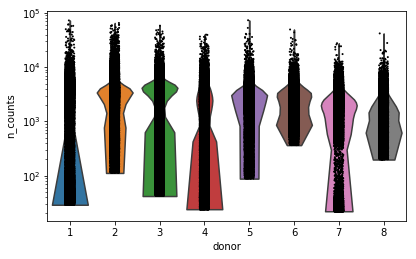

CPU times: user 8.02 s, sys: 1.77 s, total: 9.78 s
Wall time: 7.91 s


In [432]:
%time p1 = sc.pl.violin(adata, keys='n_counts', groupby='donor', log=True, size=2, cut=0)

## Cell Filter  - Count Threshold
<a href=#Table-of-Contents>back to top</a>  

In this section we come up with a minimum and maximum threshold for the number of counts each cell must have to remain in the analysis. We plot the distribution of the total number of counts per sample and zoom in at each tail. From these plots is seems that a reasonable minimum threshold would be 1000 counts since the distribution of cells below 1000 seems artificially dense. For a maximum threshold we choose 20000 since cells that have more counts than this seem to be outliers.

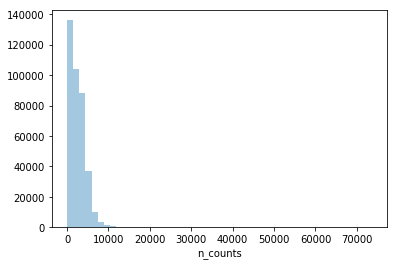

In [433]:
p2 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

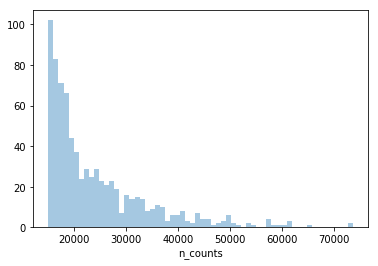

In [40]:
p3 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>15000], kde=False, bins=60)
plt.show()

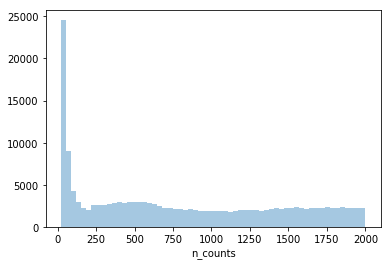

In [41]:
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], kde=False, bins=60)
plt.show()

## Cell Filter - Gene Threshold
<a href=#Table-of-Contents>back to top</a>  

Using the same approach as above, we can see that the density of samples with less than 500 genes expressed is artificially dense. We choose this for a minimum threshold.

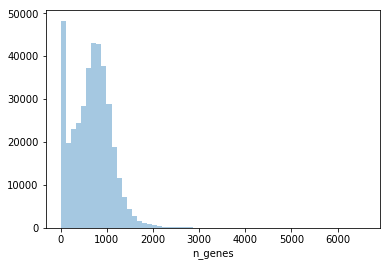

In [42]:
p5 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

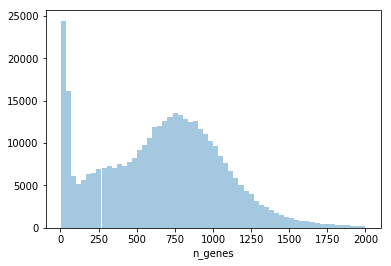

In [43]:
p6 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=60)
plt.show()

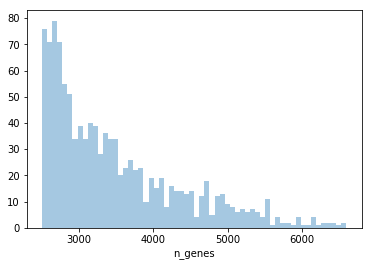

In [44]:
p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>2500], kde=False, bins=60)
plt.show()

## Remaining Cells
<a href=#Table-of-Contents>back to top</a>  

In this section we take a look at the relationship between the number of genes expressed and the total number of counts per cell. There clearly seems to be an outlier population that has a very high number of counts relative to the number of genes that are expressed. The second plot shows what this distribution looks like after we've filtered the cells that exceed our thresholds. It seems we've done a good job of eliminating the outlier group of cells.

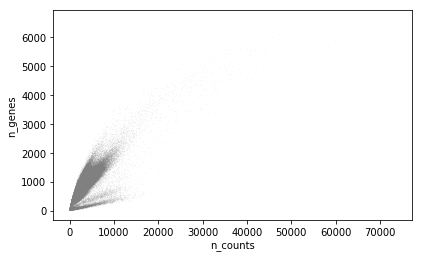

CPU times: user 5.94 s, sys: 0 ns, total: 5.94 s
Wall time: 5.4 s


In [45]:
%time p8 = sc.pl.scatter(adata, 'n_counts', 'n_genes')

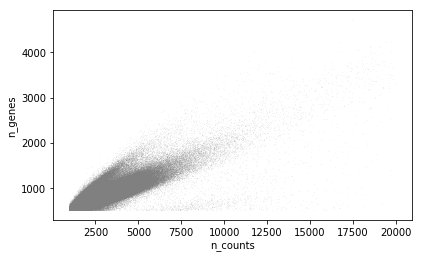

CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.69 s


In [46]:
# subset to the cells that pass the filtering criteria
count_cond = (adata.obs['n_counts'] >= 1000) & (adata.obs['n_counts'] <= 20000)
gene_cond = adata.obs['n_genes'] >= 500
%time p9 = sc.pl.scatter(adata[count_cond & gene_cond], 'n_counts', 'n_genes')

Here we reexamine the violin plots from the start of this section. We see that our proposed filtering would smooth out the overall distribution of counts. The first plot is the distribution of counts for the full data set and the second plot is the distribution of counts for the filtered data set.

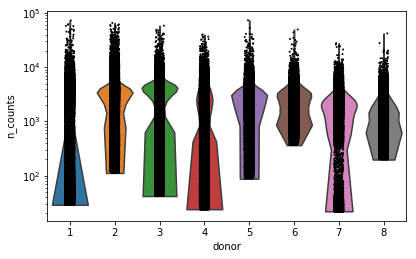

CPU times: user 7.96 s, sys: 1.63 s, total: 9.59 s
Wall time: 7.72 s


In [47]:
%time p1 = sc.pl.violin(adata, keys='n_counts', groupby='donor', log=True, size=2, cut=0)

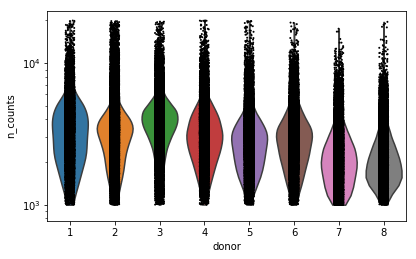

CPU times: user 5.66 s, sys: 1.85 s, total: 7.52 s
Wall time: 5.63 s


In [48]:
%time p10 = sc.pl.violin(adata[count_cond & gene_cond], keys='n_counts', groupby='donor', log=True, size=2, cut=0)

## Use the ScanpyUtilities Module to Filter
<a href=#Table-of-Contents>back to top</a>  

Now it's time to apply our proposed filter. Since this requires accessing the full data we will have to use the ScanpyUtilities module. Since we haven't modified our data from the previous job, we can actually pass the job result directly to the input of this module instead of uploading our local file. Note here that we also filter out any genes that aren't expressed in at least 20 cells. This is just a minimum baseline for determining relevant genes. This isn't necessarily a critical threshold since most of our downstream analysis will happen on a highly variable subset of genes anyways.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> ScanpyUtilities Module Instructions - Filtering the Data <i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Input and Output" select "full_data_annotated" from the <b>data file</b> dropdown</li>
    <li>Under "Input and Output" set <b>output basename</b> to "full_data"</li>
    <li>Under "Cell Filtering" set <b>cells min counts</b> to 1000</li>
    <li>Under "Cell Filtering" set <b>cells max counts</b> to 20000</li>
    <li>Under "Cell Filtering" set <b>cells min genes</b> to 500</li>
    <li>Under "Gene Filtering" set <b>genes min cells</b> to 20</li>
    <li>Everything else should be set to it's default (either blank or "no")</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [13]:
scanpypreprocess_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpypreprocess_job_spec = scanpypreprocess_task.make_job_spec()
scanpypreprocess_job_spec.set_parameter("data.file", "https://cloud.genepattern.org/gp/jobResults/100233/full_data_annotated.h5ad")
scanpypreprocess_job_spec.set_parameter("group.name", "GRCh38")
scanpypreprocess_job_spec.set_parameter("output.filename", "<data.file_basename>")
scanpypreprocess_job_spec.set_parameter("annotate", "0")
scanpypreprocess_job_spec.set_parameter("cells.min.counts", "1000")
scanpypreprocess_job_spec.set_parameter("cells.max.counts", "20000")
scanpypreprocess_job_spec.set_parameter("cells.min.genes", "500")
scanpypreprocess_job_spec.set_parameter("cells.max.genes", "")
scanpypreprocess_job_spec.set_parameter("genes.min.counts", "")
scanpypreprocess_job_spec.set_parameter("genes.max.counts", "")
scanpypreprocess_job_spec.set_parameter("genes.min.cells", "20")
scanpypreprocess_job_spec.set_parameter("genes.max.cells", "")
scanpypreprocess_job_spec.set_parameter("batch.correct.and.normalize", "False")
scanpypreprocess_job_spec.set_parameter("job.memory", "16 Gb")
scanpypreprocess_job_spec.set_parameter("job.queue", "gp-new-beta")
scanpypreprocess_job_spec.set_parameter("job.cpuCount", "4")
scanpypreprocess_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpypreprocess_task)

job100296 = gp.GPJob(genepattern.session.get(0), 100296)
genepattern.display(job100296)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=100296)

## Subset Data for Further Analysis
<a href=#Table-of-Contents>back to top</a>

At this point, we've filtered our data down to about 250,000 cells and 20,000 genes. However the 250,000 cells come from 8 donors. It is reasonable to expect a significant batch effect from these 8 donors and there are several methods for accounting for this. In this version of the notebook however, accounting for batch effects is considered out of scope. We will continue the analysis by selecting a single donor to analyze, and in future versions of the notebook we will discuss strategies for dealing with batch effects. In this section we subset down to donor 5, which has the most remaining cells after the filtering stage. After subsetting we need to do additional gene filtering. Since we just removed so many cells, it is possible that some of the genes remaining have zero expression across all cells. This can mess up certain algorithms so it's important to remember this step.

In [440]:
# download filtered result file and write locally
job = gp.GPJob(genepattern.get_session(0), 100296)
file = job.get_file("full_data_gene_filter.h5ad")
%time writeResultFileToLocal(file, "ica_cord_blood/full_data_filtered.h5ad")

file already exists!
CPU times: user 137 µs, sys: 38 µs, total: 175 µs
Wall time: 3.02 ms


In [441]:
# it is neccesary to read the full data in, without using backed='r+'
# in this case, the notebook can handle this operation since the data has been filtered
# and we are only further subsetting it
%time adata = sc.read("ica_cord_blood/full_data_filtered.h5ad")
print(adata.shape)

CPU times: user 9.8 s, sys: 1.6 s, total: 11.4 s
Wall time: 11.5 s
(252990, 19901)


In [442]:
# this cell prints out the number of cells remaining for each donor after filtering
for d in adata.obs['donor'].unique():
    print("donor:", d, "- number of cells:", sum(adata.obs['donor'] == d))

donor: 1 - number of cells: 21836
donor: 2 - number of cells: 36271
donor: 3 - number of cells: 34596
donor: 4 - number of cells: 25779
donor: 5 - number of cells: 36830
donor: 6 - number of cells: 35801
donor: 7 - number of cells: 35783
donor: 8 - number of cells: 26094


In [437]:
# this cell does the actual subsetting
adata = adata[adata.obs['donor'] == '5']
print(adata.shape)

(36830, 19901)


In [438]:
# this filters out any lowly expressed genes in the new subsetted data
# the data is small enough now to work directly in the notebook
%time sc.pp.filter_genes(adata, min_cells=20)
print(adata.shape)

CPU times: user 861 ms, sys: 912 ms, total: 1.77 s
Wall time: 1.78 s
(36830, 14661)


In [443]:
# finally we write this subset to a local file
%time adata.write("ica_cord_blood/donor_5_filtered.h5ad", compression='gzip', compression_opts=1, force_dense=False)

CPU times: user 30.7 s, sys: 229 ms, total: 30.9 s
Wall time: 36.7 s


# Cell Type Identification
<a href=#Table-of-Contents>back to top</a>  

In this section, we walk through a cell type identification workflow which is a key part of any single-cell analysis. Typically cell types are identified by running a clustering algorithm, and then selecting a handful of marker genes from the literature and seeing if they are differentially expressed across clusters. Often, this is done by hand, examining the genes uniquely expressed in each cluster. Recently, however, there have been several tools published to automate this process. The R package **garnett**, which comes from the same developers as **monocle**, is one such tool.

**garnett** works by training a classifier based on an input data set and a set of marker genes. In order to train a classifier, we first need to generate a marker file. The marker file contains a list of cell type definitions in text format. Each cell type definition starts with a `>` symbol and the cell type name, followed by definition lines. These definition lines begin with a keyword and a `:`. Keywords include `Expressed` and `Not expressed` followed by the relevant expression information for each cell type. Genes listed within the definition are separated by a comma. In our marker file we define several major immune cell types along with major subtype classifications. For more information about the **garnett** workflow, refer to the [documentation](https://cole-trapnell-lab.github.io/garnett/docs/).

Once we have the marker file generated we can use the *ScanpyUtilities* module to run the **garnett** pipeline. The module will add an additional `cell_type` annotation to our `h5ad` file. We must pass the marker file and a gene annotation database. This can be either "org.Hs.eg.db" (docs [here](https://bioconductor.org/packages/release/data/annotation/html/org.Hs.eg.db.html)) or "org.Mm.eg.db" (docs [here](https://bioconductor.org/packages/release/data/annotation/html/org.Mm.eg.db.html)). This annotation database allows **garnett** to convert the gene names we've provided in the marker file to the gene ids we've used as the index in our data. It is also important to note that we must run **garnett** before the data has been normalized. 

In [56]:
# this cell generates the cell type marker file for garnett
marker_file = open("ica_cord_blood/markers.txt","w")
marker_file.write("""
>B cells
expressed: CD19, CD38, CD24, CD34

>T cells
expressed: CD3D, CD3E, CD3G

>CD4 T cells
expressed: CD4, FOXP3, IL2RA, IL7R
subtype of: T cells

>CD8 T cells
expressed: CD8A, CD8B
subtype of: T cells

>Neutrophils
expressed: ITGAM, FCGR3A, ITGB2, FCGR2A, CD44, CD55 

>NK cells
expressed: NCAM1, FCGR3A, NCR1, KLRK1, NKG7

>DCs
expressed: CD1C, CLEC6A, CLEC7A

>pDCs
expressed: CLEC4C, NRP1, IL3RA
subtype of: DCs

>monocytes/macrophages
expressed: ITGAM, CD163, CD33, ITGAX, CD14
""")
marker_file.close()

In [57]:
# upload the local files onto the GenePattern server so we can use it in the module
data_file = "ica_cord_blood/donor_5_filtered.h5ad"
marker_file = "ica_cord_blood/markers.txt"
data_upload = genepattern.get_session(0).upload_file("ica_cord_blood_donor_5_filtered.h5ad", data_file)
marker_upload = genepattern.get_session(0).upload_file("ica_cord_blood_markers.txt", marker_file)
data_url = data_upload.get_url()
marker_url = marker_upload.get_url()
print(data_url)
print(marker_url)

https://cloud.genepattern.org/gp/users/tom.sherman/tmp/run566442466171117439.tmp/ica_cord_blood_donor_5_filtered.h5ad
https://cloud.genepattern.org/gp/users/tom.sherman/tmp/run8858562605150273614.tmp/ica_cord_blood_markers.txt


<div class="alert alert-info">
<h3 style="margin-top: 0;"> ScanpyUtilities Module Instructions - Cell Type Identification<i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Input and Output" set <b>data file</b> to "{{ data_url }}"</li>
    <li>Under "Input and Output" set <b>output basename</b> to "donor_5"</li>
    <li>Under "Cell Type Identification" set <b>cell type marker file</b> to "{{ marker_url }}"</li>
    <li>Under "Cell Type Identification" set <b>gene annotation database</b> to "org.Hs.eg.db"</li>
    <li>Everything else should be set to it's default (either blank or "no")</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [14]:
scanpyutilities_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpyutilities_job_spec = scanpyutilities_task.make_job_spec()
scanpyutilities_job_spec.set_parameter("data.file", "{{ data_url }}")
scanpyutilities_job_spec.set_parameter("output.basename", "donor_5")
scanpyutilities_job_spec.set_parameter("annotate", "0")
scanpyutilities_job_spec.set_parameter("cells.min.counts", "")
scanpyutilities_job_spec.set_parameter("cells.max.counts", "")
scanpyutilities_job_spec.set_parameter("cells.min.genes", "")
scanpyutilities_job_spec.set_parameter("cells.max.genes", "")
scanpyutilities_job_spec.set_parameter("genes.min.counts", "")
scanpyutilities_job_spec.set_parameter("genes.max.counts", "")
scanpyutilities_job_spec.set_parameter("genes.min.cells", "")
scanpyutilities_job_spec.set_parameter("genes.max.cells", "")
scanpyutilities_job_spec.set_parameter("cell.type.marker.file", "{{ marker_url }}")
scanpyutilities_job_spec.set_parameter("normalize", "0")
scanpyutilities_job_spec.set_parameter("n.high.variance.genes", "")
scanpyutilities_job_spec.set_parameter("compute.umap", "0")
scanpyutilities_job_spec.set_parameter("compute.tsne", "0")
scanpyutilities_job_spec.set_parameter("genome", "")
scanpyutilities_job_spec.set_parameter("gene.annotation.database", "org.Hs.eg.db")
scanpyutilities_job_spec.set_parameter("job.memory", "32 Gb")
scanpyutilities_job_spec.set_parameter("job.walltime", "02:00:00")
scanpyutilities_job_spec.set_parameter("job.cpuCount", "4")
genepattern.display(scanpyutilities_task)

job99227 = gp.GPJob(genepattern.session.get(0), 99227)
genepattern.display(job99227)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=99227)

# Final Pre-Processing Steps
<a href=#Table-of-Contents>back to top</a>  

Now that we have labeled the cell types with **garnett** there are just a few more preprocessing steps we need to do before running the **CoGAPS** analysis. The **CoGAPS** R package expects the data to be log normalized and also to have undergone library size normalization. Furthermore, we need to subset down to a set of highly variable genes to improve the run time of **CoGAPS**. Finally, we will want to compute the UMAP and TSNE coordinates of our data for visualizing our results.

Each of these steps can be handled completely by the *ScanpyUtilities* module. When passing parameters for multiple sections in the module, the sections are run in the order they appear in the interface. In this case, the order will be 1) normalization 2) high variance genes 3) UMAP and TSNE calculations. After each of these sections the module will write the output to a file so we can inspect the intermediate results.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> ScanpyUtilities Module Instructions - Final Pre-Processing Steps<i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Input and Output" select "donor_5_cell_types" from the <b>data file</b> dropdown </li>
    <li>Under "Input and Output" set <b>output basename</b> to "donor_5"</li>
    <li>Under "Normalization" set <b>normalize</b> to "yes"</li>
    <li>Under "High Variance Genes" set <b>n high variance genes</b> to "3000"</li>
    <li>Under "Dimension Reduction" set <b>compute umap</b> to "yes"</li>
    <li>Under "Dimension Reduction" set <b>compute tsne</b> to "yes"</li>
    <li>Everything else should be set to it's default (either blank or "no")</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [15]:
scanpypreprocess_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpypreprocess_job_spec = scanpypreprocess_task.make_job_spec()
scanpypreprocess_job_spec.set_parameter("data.file", "https://cloud.genepattern.org/gp/jobResults/99227/donor_5_cell_types.h5ad")
scanpypreprocess_job_spec.set_parameter("output.basename", "donor_5")
scanpypreprocess_job_spec.set_parameter("annotate", "0")
scanpypreprocess_job_spec.set_parameter("cells.min.counts", "")
scanpypreprocess_job_spec.set_parameter("cells.max.counts", "")
scanpypreprocess_job_spec.set_parameter("cells.min.genes", "")
scanpypreprocess_job_spec.set_parameter("cells.max.genes", "")
scanpypreprocess_job_spec.set_parameter("genes.min.counts", "")
scanpypreprocess_job_spec.set_parameter("genes.max.counts", "")
scanpypreprocess_job_spec.set_parameter("genes.min.cells", "")
scanpypreprocess_job_spec.set_parameter("genes.max.cells", "")
scanpypreprocess_job_spec.set_parameter("normalize", "1")
scanpypreprocess_job_spec.set_parameter("n.high.variance.genes", "3000")
scanpypreprocess_job_spec.set_parameter("compute.umap", "1")
scanpypreprocess_job_spec.set_parameter("compute.tsne", "1")
scanpypreprocess_job_spec.set_parameter("genome", "")
scanpypreprocess_job_spec.set_parameter("job.memory", "64Gb")
scanpypreprocess_job_spec.set_parameter("job.queue", "gpbeta-default")
scanpypreprocess_job_spec.set_parameter("job.cpuCount", "4")
scanpypreprocess_job_spec.set_parameter("job.walltime", "04:00:00")
genepattern.display(scanpypreprocess_task)

job99247 = gp.GPJob(genepattern.session.get(0), 99247)
genepattern.display(job99247)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=99247)

As you can see there are two files returned after subsetting the highly variable genes. One is the full data set with the highly variable genes labeled, and the other is just the highly variable subset. When running multiple sections, this is the file that gets passed downstream. So, "donor_5_dim_reduce.h5ad" will be a small file with just the highly variable genes and the UMAP and TSNE coordinates already computed. This is the file we want to work with going forward and we will offically consider the pre-processing phase completed.

In [58]:
job = gp.GPJob(genepattern.get_session(0), 99247)
file = job.get_file("donor_5_dim_reduce.h5ad")
%time writeResultFileToLocal(file, "ica_cord_blood/donor_5_preprocessed.h5ad")

CPU times: user 430 ms, sys: 172 ms, total: 602 ms
Wall time: 4.58 s


# Visualization
<a href=#Table-of-Contents>back to top</a>  

In this section we show how to use the **scanpy** package to plot both the UMAP and TSNE representations of the data. We can clearly see that there is separation between the different 10x channels and that some cell types are separated. However, these methods are primarily for visualization and more analytical methods are needed before we can make any claims. In the next section we explore a matrix factorization algorithm, **CoGAPS**, which helps identify the underlying biological processes which drive the signal in the data.

In [462]:
adata = sc.read("ica_cord_blood/donor_5_preprocessed.h5ad")
print(adata.shape)

(36830, 3000)


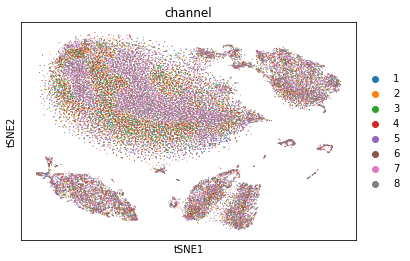

In [463]:
sc.pl.tsne(adata, color='channel', use_raw=False)

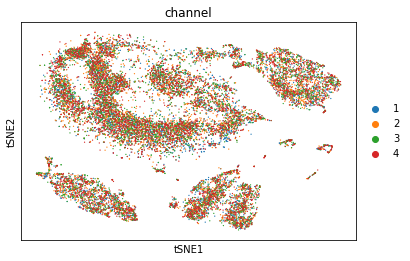

In [464]:
ndx = [i for i, e in enumerate(adata.obs['channel']) if e in ['1','2','3','4']]
sc.pl.tsne(adata[ndx], color='channel')

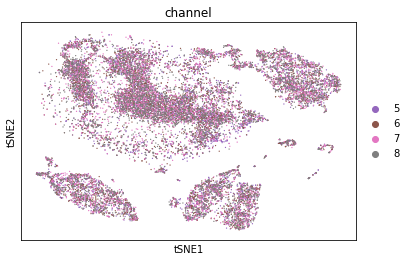

In [465]:
ndx = [i for i, e in enumerate(adata.obs['channel']) if e in ['5','6','7','8']]
sc.pl.tsne(adata[ndx], color='channel')

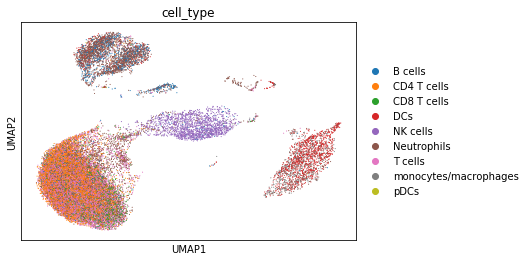

In [466]:
sc.pl.umap(adata[adata.obs['cell_type'] != 'Unknown'], color='cell_type')

# CoGAPS Analysis
<a href=#Table-of-Contents>back to top</a>  

In this section we go through an entire **CoGAPS** workflow and carefully detail all of the considerations that need to be taken into account when running the algorithm. **CoGAPS** is an R package which has a GenePattern module wrapper. This means we can launch jobs directly through the module, but then also analyze the result using R. The algorithm itself is a non-negative matrix factorization method. These methods rely on the principle that interrelated gene regulatory mechanisms, gene-gene interactions, and cellular interactions induce a low-dimensional structure within the fundamentally high-dimensional data produced with high-throughput technologies. Matrix Factorization techniques can learn this low-dimensional representation and have been successfully used in the past [7]. **CoGAPS** is similar to other non-negative matrix factorization algorithms, but it adds an additional sparsity constraint on the learned low-dimensional representation.

In [478]:
# the data we are running CoGAPS on
adata = sc.read("ica_cord_blood/donor_5_preprocessed.h5ad")
print(adata.shape)

(36830, 3000)


## Setting up a CoGAPS Run
<a href=#Table-of-Contents>back to top</a>  

There are two things we must do before starting a **CoGAPS** run. First we must create a parameters object in R and save it to a file, and second we must convert our data to a format that **CoGAPS** accepts. In the case of single-cell data this will almost always be a `.mtx` file due to the sparsity of the data. For the parameters file, we can either create a **CogapsParams** object in R and save it to a file, or we can use the provided UI cell which does this for us. There are a handful of parameters to consider so we describe their relevance here.

*num patterns* - this is the most fundamental parameter. It controls the size of the low-dimensional representation of the data. The optimal value is not known and it is even debatable if there is a single best value for a given data set. It is likely that for different values of *num patterns*, the underlying biological behavior will be learned at a different resolution. For this reason, it is common to run **CoGAPS** over a range of *num patterns* and analyze the differences between the runs. In this case, we will start off with 20 patterns and see how the analysis goes. In future versions of the notebook we will explore a range of values for this parameter.

*num iterations* - this controls how many iterations the algorithm will run for. Determining when the algorithm has converged is not an exact science, so typically a large value in neighborhood of 50,000 iterations is recommended to be safe.

*seed* - this is the random seed, used for reproducibility

*single cell* - this should be set to TRUE when running on single-cell data. It changes the underlying mathematics of the algorithm to account for the sparsity present in single-cell data.

*sparse optimization* - this has no effect on the mathematics of the algorithm and is purely used for improving the run time. It is recommended to set this to TRUE when the sparsity of the data is over 80% (i.e. 80% of the data is zero).

*gene names* and *sample names* - this is an optional field for setting the gene and sample names of the data. Since an `.mtx` file contains no text data, it is required in our case. Some other file formats make it possible to infer these names.

*distributed method* - this is perhaps the second most critical parameter to account for. By default, **CoGAPS** will run the factorization on the entire data set, using only a single cpu core. For large data sets, this makes it completely impractical to use since the run time is so long. When running on large data sets such as this one, this parameter enables a distributed version of the algorithm. This version of the algorithm splits the data into subsets and runs the standard algorithm on each subset in parallel. If the value of this parameter is "genome-wide" the data set is broken into subsets of genes, if the value is "single-cell" the data set is broken into subsets of cells. Once the parallel runs finish, there is an internal method for matching the common patterns between subsets and stitching them together to form a final result. This provides an additional benefit since patterns which are not robust across subsets are thrown out. In this way, the value for *num patterns* is less critical since only robust patterns are kept [5].

*num sets* - this parameter controls how many subsets are run in parallel when using the distributed version of the algorithm. In this case we break the data into 12 sets which gives us about 3000 cells per subset. We want to make sure each subset has at least 1000 or 2000 cells in order give robust results, but ideally we would want as many cells per set as possible.

In [479]:
# dimensions and sparsity of the data
print(adata.shape)
sparsity = 1 - adata.X.getnnz() / (adata.shape[0] * adata.shape[1])
print(round(sparsity, 2))

(36830, 3000)
0.91


In [480]:
# extract the gene and sample names since .mtx format only stores count data
gene_names = adata.var_names
sample_names = adata.obs_names

<div class="alert alert-info">
<h3 style="margin-top: 0;"> createCogapsParams Instructions<i class="fa fa-info-circle"></i></h3>
<ol>
    <li>set <b>param file name</b> to "ica_cord_blood/donor_5_cogaps_params"</li>
    <li>set <b>num patterns</b> to "20"</li>
    <li>set <b>num iterations</b> to "50000"</li>
    <li>set <b>seed</b> to "42"</li>
    <li>set <b>single cell</b> to "TRUE"</li>
    <li>set <b>sparse optimization</b> to "TRUE"</li>
    <li>set <b>gene names</b> to "gene_names"</li>
    <li>set <b>sample names</b> to "sample_names"</li>
    <li>set <b>distributed method</b> to "single-cell"</li>
    <li>set <b>num sets</b> to "12"</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

In [8]:
import genepattern

@genepattern.build_ui(
    description="Create CoGAPS Parameters File",
    parameters={
    "n_patterns": {
        "type": "text"
    },
    "output_var": {
        "name": "ignoreme",
        "hide": True,
    }
})

def createCogapsParams(param_file_name, num_patterns, num_iterations, seed, single_cell, sparse_optimization, gene_names, sample_names, distributed_method, num_sets):
    %R -i param_file_name -i num_patterns -i num_iterations -i seed -i single_cell -i sparse_optimization -i gene_names -i sample_names -i distributed_method -i num_sets
    %R library(CoGAPS)
    %R params <- CogapsParams(nPatterns=num_patterns, nIterations=num_iterations, seed=seed, singleCell=single_cell, sparseOptimization=sparse_optimization, distributed=distributed_method, geneNames=gene_names, sampleNames=sample_names)
    %R params <- setDistributedParams(params, nSets=num_sets)
    %R print(params)
    %R saveRDS(params, file=paste(param_file_name, "rds", sep="."))
    %R print(paste("successfully created file:", paste(param_file_name, "rds", sep=".")))

UIBuilder(description='Create CoGAPS Parameters File', function_import='createCogapsParams', name='createCogap…

In this next cell we use the R packages **Matrix** and **rhdf5** to read from our preprocessed `.h5ad` file and write the normalized count data to an `.mtx` file. Once that file is created, we can upload it and the parameter file so that we can use them as input for the module. Notice that the module has both an option for a parameter file and *num patterns*, *num iterations*. The manually specified values in the module will always overwrite the parameters given in the file. This is so a single parameter file can be used with a range of values for *num patterns*.

In [72]:
%%R

suppressMessages(library(Matrix))
suppressMessages(library(rhdf5))

adata_file <- "ica_cord_blood/donor_5_preprocessed.h5ad"
raw_data <- as.numeric(h5read(adata_file, "/X/data"))
indices <- as.integer(h5read(adata_file, "/X/indices"))
indptr <- as.integer(h5read(adata_file, "/X/indptr"))
counts <- sparseMatrix(i=indices+1, p=indptr, x=raw_data)
print(dim(counts))
writeMM(counts, file="ica_cord_blood/donor_5_preprocessed.mtx")

[1]  3000 36830
NULL


In [73]:
# upload the local files onto the GenePattern server so we can use them in the module
data_file = "ica_cord_blood/donor_5_preprocessed.mtx"
param_file = "ica_cord_blood/donor_5_cogaps_params.rds"
data_upload = genepattern.get_session(0).upload_file("ica_cord_blood_donor_5_preprocessed.mtx", data_file)
param_upload = genepattern.get_session(0).upload_file("ica_cord_blood_cogaps_params.rds", param_file)
data_url = data_upload.get_url()
param_url = param_upload.get_url()
print(data_url)
print(param_url)

https://cloud.genepattern.org/gp/users/tom.sherman/tmp/run241744030082916586.tmp/ica_cord_blood_donor_5_preprocessed.mtx
https://cloud.genepattern.org/gp/users/tom.sherman/tmp/run6865633091433305614.tmp/ica_cord_blood_cogaps_params.rds


<div class="alert alert-info">
<h3 style="margin-top: 0;"> CoGAPS Module Instructions<i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Under "Basic Parameters" set <b>data file</b> to "{{ data_url }}"</li>
    <li>Under "Basic Parameters" set <b>output file</b> to "donor-5-patterns-20-cogaps-result"</li>
    <li>Under "Basic Parameters" set <b>num patterns</b> to "20"</li>
    <li>Under "Basic Parameters" set <b>num iterations</b> to "50000"</li>
    <li>Under "Parameter File" set <b>param file</b> to "{{ param_url }}"</li>
    <li>Under "Miscellaneous" set <b>transpose data</b> to "False"</li>
    <li>In the top right corner click the settings icon and click "Toggle Job Options" to enable this section</li>
    <li>Under "Job Options" set <b>job cpuCount</b> to "12"</li>
    <li>Under "Job Options" set <b>job queue</b> to "CoGAPS"</li>
</ol>
Note: do not include the quotes when setting parameters
</div>

<div class="alert alert-warning">
<h3 style="margin-top: 0;"> CoGAPS Running Time<i class="fa fa-info-circle"></i></h3>
This module launches a CoGAPS run that takes about 30 hours - it is recommended to use the pre-generated result if you are trying out the notebook.
</div>

In [16]:
cogaps_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00376')
cogaps_job_spec = cogaps_task.make_job_spec()
cogaps_job_spec.set_parameter("data.file", "{{ data_url }}")
cogaps_job_spec.set_parameter("output.file", "donor-5-patterns-20-cogaps-result")
cogaps_job_spec.set_parameter("num.patterns", "20")
cogaps_job_spec.set_parameter("num.iterations", "50000")
cogaps_job_spec.set_parameter("param.file", "{{ param_url }}")
cogaps_job_spec.set_parameter("transpose.data", "FALSE")
cogaps_job_spec.set_parameter("github.tag", "")
cogaps_job_spec.set_parameter("job.memory", "32 Gb")
cogaps_job_spec.set_parameter("job.queue", "CoGAPS")
cogaps_job_spec.set_parameter("job.cpuCount", "12")
cogaps_job_spec.set_parameter("job.walltime", "")
genepattern.display(cogaps_task)

job99260 = gp.GPJob(genepattern.session.get(0), 99260)
genepattern.display(job99260)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00376')

GPJobWidget(job_number=99260)

## Processing the CoGAPS Result
<a href=#Table-of-Contents>back to top</a>  

Now that we have the results from the **CoGAPS** run, we will take some extra time here to process the results so that the downstream analysis is easier. This mainly concerns the way in which we pull out the information from the **CoGAPS** result and store it in our `.h5ad` file.

In [22]:
## first we download the file and write it locally
job = gp.GPJob(genepattern.get_session(0), 99260)
file = job.get_file("donor-5-patterns-20-cogaps-result.rds")
%time writeResultFileToLocal(file, "ica_cord_blood/donor_5_patterns_20_cogaps_result.rds")

CPU times: user 153 ms, sys: 80.2 ms, total: 233 ms
Wall time: 1.07 s


In [52]:
## here we load the original data
adata = sc.read("ica_cord_blood/donor_5_preprocessed.h5ad")

This next cell loads the result file into a local R variable called *cogapsResult*. It also prints some information about the result and the parameters used to generate it.

In [44]:
%%R

library(CoGAPS)
cogapsResult <- readRDS("ica_cord_blood/donor_5_patterns_20_cogaps_result.rds")
print(cogapsResult)
print(getOriginalParameters(cogapsResult))

[1] "CogapsResult object with 3000 features and 36830 samples"
[1] "18 patterns were learned"
-- Standard Parameters --
nPatterns            20 
nIterations          50000 
seed                 42 
singleCell           TRUE 
sparseOptimization   TRUE 
distributed          single-cell 

-- Sparsity Parameters --
alpha          0.01 
maxGibbsMass   100 

-- Distributed CoGAPS Parameters -- 
nSets          12 
cut            20 
minNS          6 
maxNS          18 


Here we extract the matrix of sample weights for each of the patterns learned from **CoGAPS**. We must also get the sample names since they aren't returned in the **numpy** array *samplePatterns*. These are necessary since the order of dimensions is not guaranteed to be the same as in the original data, so we might need to re-order the rows.

In [504]:
%%R -o samplePatterns -o sampleNames
samplePatterns <- getSampleFactors(cogapsResult)
sampleNames <- rownames(samplePatterns)

In [505]:
print(type(samplePatterns))
print(samplePatterns.shape)

# check if samples are in the same order
print("order of samples matches:", all(sampleNames == adata.obs.index))

<class 'numpy.ndarray'>
(36830, 18)
order of samples matches: False


In this case, we have to re-order the samples since the order in the result is different than the order in the original data. We do this by matching the indices of the sample names in the result to the labels of the data.

In [58]:
# reorder samplePatterns to match the order in the original data
sampleNames = list(sampleNames)
%time matched_ndx = [sampleNames.index(x) for x in adata.obs.index]
samplePatterns = samplePatterns[matched_ndx,:]
sampleNames = [sampleNames[i] for i in matched_ndx]
print("order of samples matches:", all(sampleNames == adata.obs.index))

CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.2 s
order of samples matches: True


In [59]:
# now that the order matches, we can store the CoGAPS pattern weights in the anndata object
nPatterns = samplePatterns.shape[1]
for i in range(nPatterns):
    adata.obs['cogaps.pattern.' + str(i+1)] = samplePatterns[:,i]

Here we do the same process for the feature weights. In addition to the raw value of the patterns, we also return the ranks of each gene in each pattern. This will prove useful for cell type identification later on.

In [61]:
%%R -o featurePatterns -o featureNames
featurePatterns <- getFeatureLoadings(cogapsResult)
featureNames <- rownames(featurePatterns)

In [63]:
print(type(featurePatterns))
print(featurePatterns.shape)

# check if samples are in the same order
print("order of features matches:", all(featureNames == adata.var.index))

<class 'numpy.ndarray'>
(3000, 18)
order of features matches: True


In [75]:
%%R -o patternRanks

pm <- patternMarkers(cogapsResult)
patternRanks <- pm$PatternRanks

In [76]:
print(type(patternRanks))
print(patternRanks.shape)

<class 'numpy.ndarray'>
(3000, 18)


In [77]:
for i in range(nPatterns):
    adata.var['cogaps.pattern.' + str(i+1)] = featurePatterns[:,i]
    adata.var['cogaps.pattern.rank.' + str(i+1)] = patternRanks[:,i].astype(int)

In [79]:
# once all the result data is stored, write the anndata object to a file for future use
%time adata.write("ica_cord_blood/donor_5_cogaps_result.h5ad", compression='gzip', compression_opts=1)

CPU times: user 3.29 s, sys: 157 ms, total: 3.45 s
Wall time: 5.31 s


## Visualizing Patterns
<a href=#Table-of-Contents>back to top</a>  

Visualizing the patterns learned from **CoGAPS** is an important task, but it is not enough to make definitive statements about the biological relevance of specific patterns - we will get to that in the next section. For now, we show some ways that patterns can visualized and point out some interesting examples. We note that this visualization can be applied to the results from all sample weight matrices learned from matrix factorization approaches [7].

In [25]:
# read the data in and calculate the number of patterns available
adata = sc.read("ica_cord_blood/donor_5_cogaps_result.h5ad")
nPatterns = len([x for x in adata.var_keys() if 'cogaps.pattern' in x and 'rank' not in x])

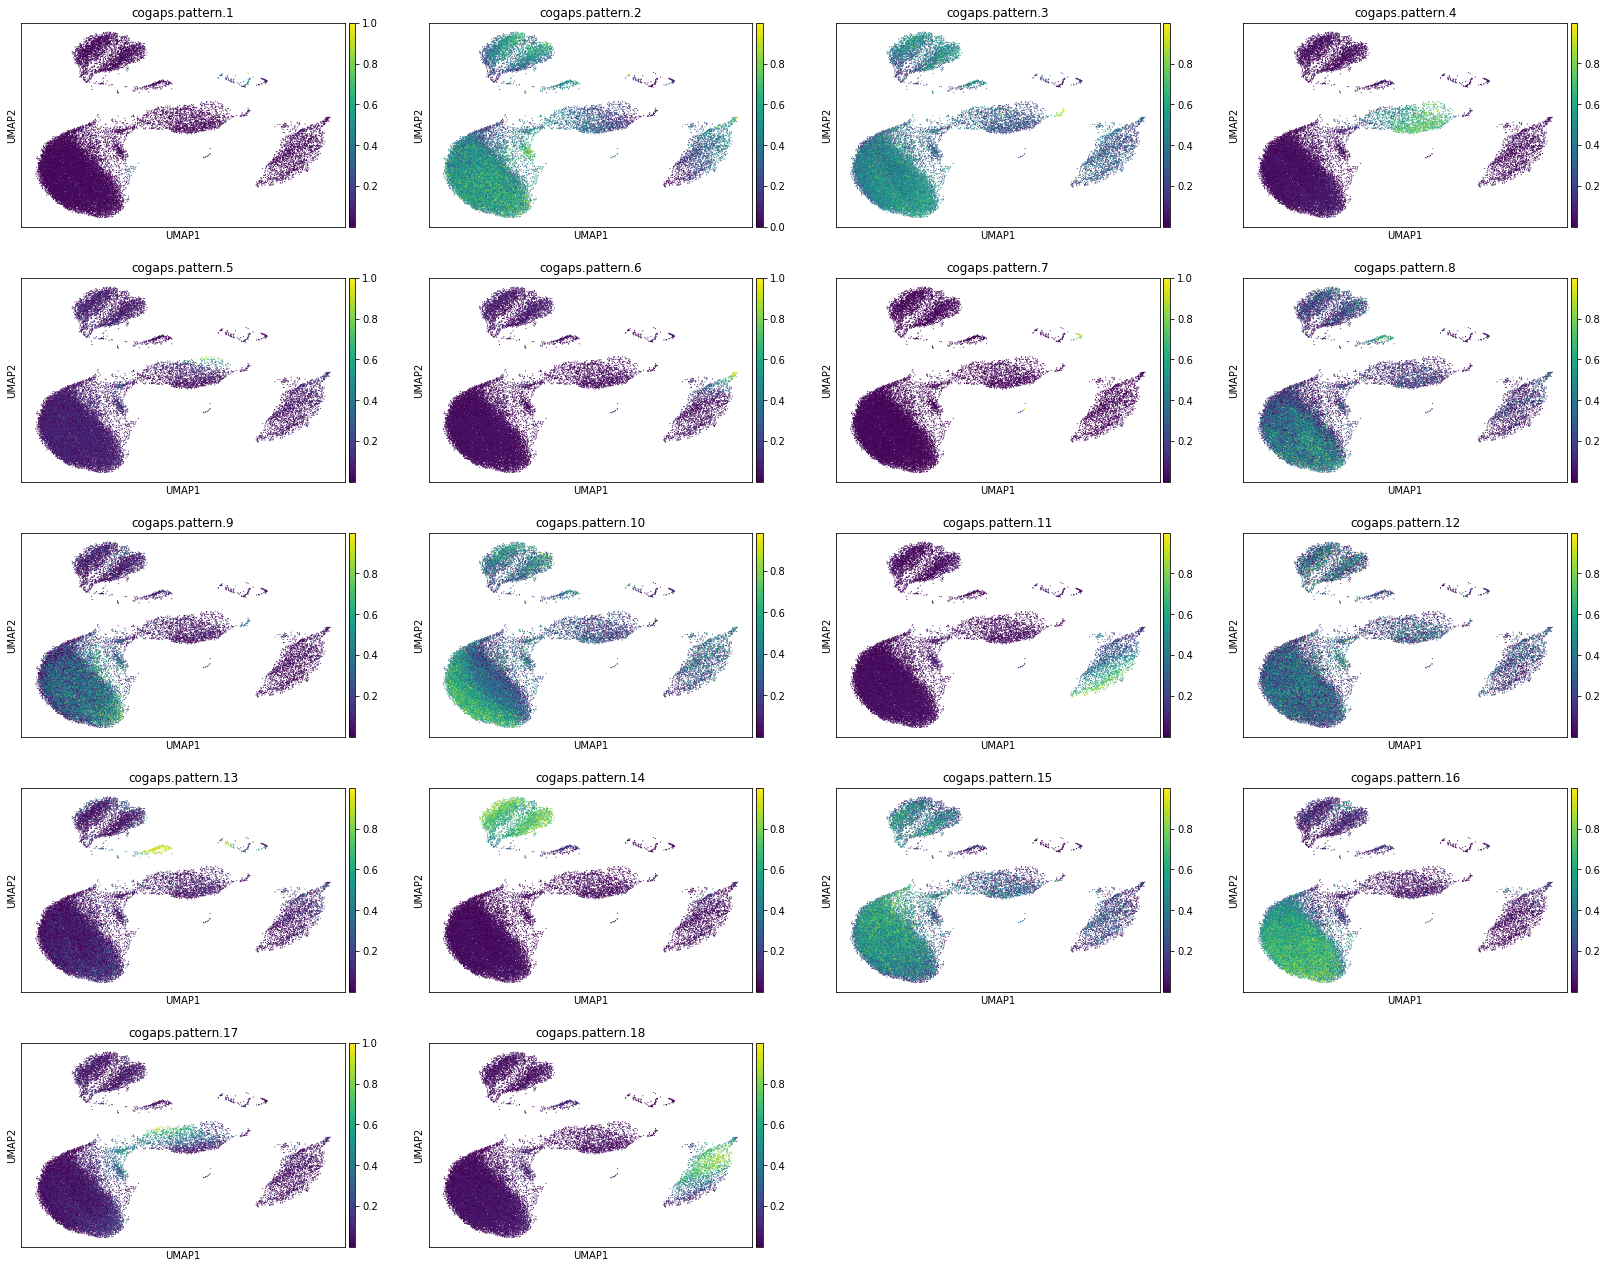

In [509]:
# Here we plot a umap colored by the pattern weight for each pattern separately
sc.pl.umap(adata[adata.obs['cell_type'] != 'Unknown'], color=['cogaps.pattern.' + str(i+1) for i in range(nPatterns)])

When there are a large number of patterns, or perhaps the previous plot is unwanted, this UI cell allows us to plot the patterns interactively. We can select which pattern is currently highlighted using a drop down.

In [22]:
from ipywidgets import widgets, interact

class WrappedAnnData(object):
    def __init__(self):
        self.adata = sc.AnnData()
        self.vis_coord = 'UMAP'
        
    def process(self, adata, vc):
        self.adata = adata
        self.vis_coord = vc

    def plot(self, pattern):
        if self.vis_coord == 'UMAP':
            sc.pl.umap(self.adata, color=["cogaps.pattern." + str(pattern)])
        else:
            sc.pl.tsne(self.adata, color=["cogaps.pattern." + str(pattern)])

wrappedAData = WrappedAnnData()

def f(x):
    wrappedAData.plot(x)

wid = widgets.BoundedIntText(
    value=1,
    min=1,
    max=200,
    step=1,
    description='Pattern:',
    disabled=False
)

@genepattern.build_ui(
    description="Interactive umap/tsne plot of the original data, colored by the specified CoGAPS pattern ",
    parameters={
    "Visualization_Coordinates": {
          "description": "either UMAP or TSNE"
    },
    "output_var": {
        "name": "ignoreme",
        "hide": True,
    }
})

def plotCogapsPatterns(AnnData_Object, Visualization_Coordinates):
    if Visualization_Coordinates not in ['UMAP', 'TSNE']:
        sys.exit("Visualization Coordinates must be either UMAP or TSNE")
    wrappedAData.process(AnnData_Object, Visualization_Coordinates)
    interact(f, x=wid)

UIBuilder(description='Interactive umap/tsne plot of the original data, colored by the specified CoGAPS patter…

The next two plots are interesting examples of patterns that seem to be strongly associated with a particular phenotype. In the next section we will make this association more precise, but it is worth looking at visualization like this to identify candidate patterns for later analysis.

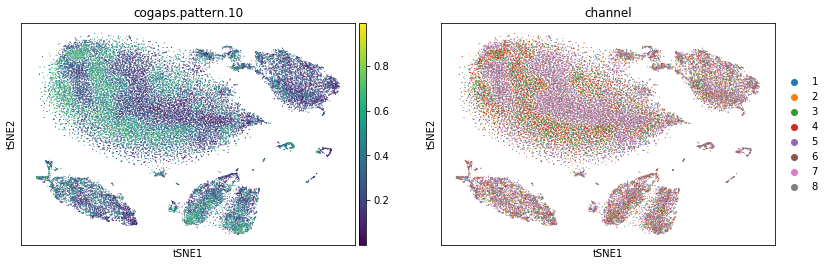

In [516]:
# pattern 10 pretty much replicates the effect seen from the 10x channel
sc.pl.tsne(adata, color=['cogaps.pattern.10', 'channel'])

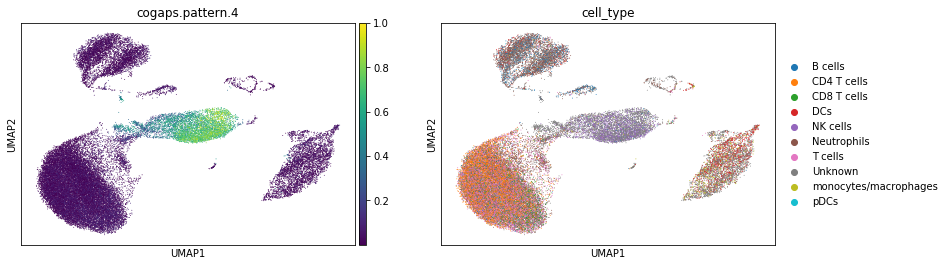

In [517]:
# plot all known cell types, pattern 4 seems to be associated with NK cells
sc.pl.umap(adata[adata.obs['cell_type'] != 'Unkown'], color=['cogaps.pattern.4', 'cell_type'])

## Analyzing Patterns
<a href=#Table-of-Contents>back to top</a>  

In this section we dive into a more rigorous analysis of the patterns learned from **CoGAPS**. The types of analysis we might do breaks into several groups. First, when we have known phenotypes (e.g. donor, channel) we can directly see which patterns show a statistically significant separation of the phenotype. Second, we can do cell type identification using the marker genes we've previously described. By looking at which patterns are uniquely associated with the marker genes, we can label patterns as being an indicator for a given cell type. Finally, there are some patterns that aren't clearly associated with either of the former categories and so we must take a more exploratory approach to identifying their relevance.

In [9]:
# read the data in a calculate the number of patterns available
adata = sc.read("ica_cord_blood/donor_5_cogaps_result.h5ad")
nPatterns = len([x for x in adata.var_keys() if 'cogaps.pattern' in x and 'rank' not in x])

### Known Phenotypes
<a href=#Table-of-Contents>back to top</a>  

In this case, we are trying to see if any patterns separate the different 10x channels. The null hypothesis would be that all 8 populations from the 8 different channels have the same distribution. We can test whether or not this is true with an ANOVA test. In this case, we use the non-parametric version of ANOVA, the Kruskal-Wallis test. We calculate the statistic and p-value for each of the patterns. Note that pattern 10, which was visually identified in the previous section, has a test statistic an order of magnitude larger than any other pattern. It seems clear that this pattern is separating the 10x channel, however the p-values for almost all patterns are "significant". Obviously, some correction needs to be used when calculating p-values in this manner and we will explore that in future versions of the notebook. For now, we justify the relevance of pattern 10 with the test statistic alone.

    pattern  Kruskal-Wallis Statistic        p-value
0        10              10123.547196   0.000000e+00
1         7               1141.276276  3.517506e-242
2         2                340.378263   1.412347e-69
3        13                286.890845   3.803356e-58
4         8                242.782870   9.510987e-49
5        14                113.636315   1.614422e-21
6         4                 76.339395   7.663817e-14
7        15                 71.267239   8.189376e-13
8        16                 71.072260   8.968091e-13
9         1                 68.120786   3.539103e-12
10        3                 64.078686   2.302741e-11
11       11                 48.317174   3.086737e-08
12       18                 45.831864   9.425839e-08
13        9                 43.653803   2.493564e-07
14        5                 40.226278   1.139282e-06
15       17                 37.362994   4.003406e-06
16       12                 30.665658   7.164997e-05
17        6                 16.954277   1.7693

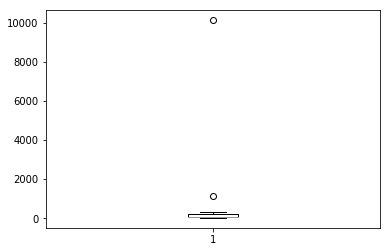

In [31]:
# get the indices for the cells in each channel
ndx = []
for n in range(8):
    ndx.append([i for i, x in enumerate(adata.obs['channel']) if x == str(n+1)])

# compute a kruskal-wallis test across all channels for each of the patterns
channel_stats = []
for i in range(nPatterns):
    p = adata.obs['cogaps.pattern.' + str(i+1)]
    kw_test = ss.kruskal(p[ndx[0]], p[ndx[1]], p[ndx[2]], p[ndx[3]], p[ndx[4]], p[ndx[5]], p[ndx[6]], p[ndx[7]])
    channel_stats.append([i+1, kw_test.statistic, kw_test.pvalue])

# sort, print, and plot the results of the test
channel_stats.sort(key= lambda x: x[1], reverse=True)
print(pd.DataFrame(channel_stats, columns=['pattern', 'Kruskal-Wallis Statistic', 'p-value']))
plt.boxplot([s[1] for s in channel_stats])
plt.show()

Now that we've identified pattern 10 as separating the 10x channels, we can use a post-hoc test to see specifically which channels are separated. The [Dunn Test](https://cran.r-project.org/web/packages/dunn.test/dunn.test.pdf) is a non-parametric test designed to work in conjunction with the Kruskal-Wallis test. We use the R package **dunn.test** to evaluate pattern 10. We can see that channels 1,2,3,4 are strongly separated from channels 5,6,7,8 - but within those groups there is not as much separation. This is something we had already seen visually in the UMAP/TSNE plots.

In [32]:
cogaps_pattern_10 = adata.obs['cogaps.pattern.10']

In [33]:
%%R -i cogaps_pattern_10 -i ndx

library(dunn.test)

ndx <- lapply(ndx, unlist)
pattern_10_by_channel <- lapply(ndx, function(n) cogaps_pattern_10[n])
dunn.test(pattern_10_by_channel, kw=TRUE, wrap=TRUE)

  Kruskal-Wallis rank sum test

data: pattern_10_by_channel and group
Kruskal-Wallis chi-squared = 10120.7382, df = 7, p-value = 0


                 Comparison of pattern_10_by_channel by group                  
                                (No adjustment)                                
Col Mean-|
Row Mean |          1          2          3          4          5          6          7
---------+-----------------------------------------------------------------------------
       2 |   12.53924
         |    0.0000*
         |
       3 |   12.96411   0.575593
         |    0.0000*     0.2824
         |
       4 |   10.11670  -2.402714  -2.948382
         |    0.0000*    0.0081*    0.0016*
         |
       5 |   62.84168   50.75243   49.59992   52.98993
         |    0.0000*    0.0000*    0.0000*    0.0000*
         |
       6 |   61.91813   49.65418   48.48998   51.92479  -1.802136
         |    0.0000*    0.0000*    0.0000*    0.0000*     0.0358
         |
       7 |   56.77852   4

### Cell Type Identification with CoGAPS
<a href=#Table-of-Contents>back to top</a>  

Here we do cell type identification by using the previously described marker genes. We can first take a look at the correlation between the pattern weights and the cell types found by **garnett**. This isn't necessarily informative since **garnett** cell types do not form a ground truth, but the comparison is still interesting. Only one pattern, 4, really seems associated with any of the **garnett** cell types (NK cells).

In [12]:
# get the indices of each of the cell types
cell_types = adata.obs['cell_type'].unique()
cell_types = [x for x in cell_types if x != 'Unknown']
cell_type_index = {}
for ct in cell_types:
    cell_type_index[ct] = adata.obs['cell_type'] == ct

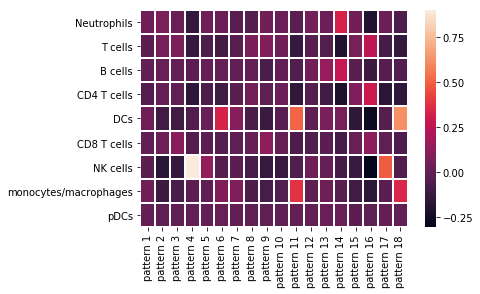

In [16]:
# find the correlation for each cell type and each pattern
known = adata.obs['cell_type'] != 'Unknown'
cell_type_pattern_corr = []
for ct in cell_types:
    corr = []
    for i in range(nPatterns):
        corr.append(ss.pointbiserialr(cell_type_index[ct][known], adata.obs['cogaps.pattern.' + str(i+1)][known]).correlation)
    cell_type_pattern_corr.append(corr)
    
# form a heatmap of the correlations
cell_type_pattern_corr = np.array(cell_type_pattern_corr)
ax = sb.heatmap(cell_type_pattern_corr, linewidth=1, yticklabels=cell_types, xticklabels=['pattern '+str(i+1) for i in range(nPatterns)])
plt.show()

Here we demonstrate the cell type identification process using marker genes. We print out the top 3 patterns by rank for each marker. Using this we can see the patterns which are most influenced by all marker genes for a particular type.

In [17]:
# marker gene from previous section
cell_type_markers = {}
cell_type_markers['B_cells'] = ['CD19', 'CD38', 'CD24', 'CD34']
cell_type_markers['T_cells'] = ['CD3D', 'CD3E', 'CD3G']
cell_type_markers['CD4_T_cells'] = ['CD4', 'FOXP3', 'IL2RA', 'IL7R']
cell_type_markers['CD8_T_cells'] = ['CD8A', 'CD8B']
cell_type_markers['Neutrophils'] = ['ITGAM', 'FCGR3A', 'ITGB2', 'FCGR2A', 'CD44', 'CD55']
cell_type_markers['NK_cells'] = ['NCAM1', 'FCGR3A', 'NCR1', 'KLRK1', 'NKG7']
cell_type_markers['DCs'] = ['CD1C', 'CLEC6A', 'CLEC7A']
cell_type_markers['pDCs'] = ['CLEC4C', 'NRP1', 'IL3RA']
cell_type_markers['monocytes_macrophages'] = ['ITGAM', 'CD163', 'CD33', 'ITGAX', 'CD14']

In [18]:
# print top 3 patterns by rank for each marker gene
for cell_type in cell_type_markers.keys():
    ndx = [i for i, x in enumerate(adata.var['gene_short_name']) if x in cell_type_markers[cell_type]]
    print("\nmarker genes found for", cell_type)
    for n in ndx:
        gene_name = adata.var['gene_short_name'][n]
        ranks = [adata.var[k][n] for k in adata.var_keys() if 'rank' in k]
        ranks = np.array(ranks)
        top3 = np.argsort(ranks)[:3]
        print(gene_name, "\ttop 3 patterns:", top3 + 1, "\tranks:", ranks[top3])


marker genes found for B_cells
CD34 	top 3 patterns: [ 2  8 13] 	ranks: [ 29 147 299]
CD24 	top 3 patterns: [14 13  5] 	ranks: [ 118 1023 1206]
CD19 	top 3 patterns: [14 10 12] 	ranks: [ 56 819 848]

marker genes found for T_cells
CD3G 	top 3 patterns: [ 9 16  3] 	ranks: [   6   28 1850]

marker genes found for CD4_T_cells
IL2RA 	top 3 patterns: [ 5 17 13] 	ranks: [  75   87 1724]

marker genes found for CD8_T_cells
CD8A 	top 3 patterns: [ 9 16  4] 	ranks: [103 143 191]
CD8B 	top 3 patterns: [ 9 16  3] 	ranks: [   4   43 2142]

marker genes found for Neutrophils
FCGR2A 	top 3 patterns: [11 18  1] 	ranks: [345 348 480]
FCGR3A 	top 3 patterns: [ 4  5 10] 	ranks: [ 24  64 775]
ITGAM 	top 3 patterns: [11  4 13] 	ranks: [ 140  146 2156]
ITGB2 	top 3 patterns: [ 4 11  6] 	ranks: [ 70 193 720]

marker genes found for NK_cells
FCGR3A 	top 3 patterns: [ 4  5 10] 	ranks: [ 24  64 775]
NKG7 	top 3 patterns: [ 4 17 10] 	ranks: [ 15 139 604]

marker genes found for DCs
CLEC7A 	top 3 patterns: [18 

If we look at the marker genes for `NK cells` we can see that both marker genes have a high rank in pattern 4. This is consistent with what we saw visually and the correlation heatmap we made in the previous section. If we make a umap plot with just the `NK cells` from **garnett** highlighted, we can see a strong correlation with pattern 4. What's interesting is that the marker genes for `Neutrophils` also have a high rank in pattern 4, as well as pattern 11. However, if we plot those patterns on the `Neutrophils` generated by **garnett**, we can see there is little agreement. As is often the case, we have to do a deeper dive in order to get a sense of how cell types are related to patterns. This is done in the next section.

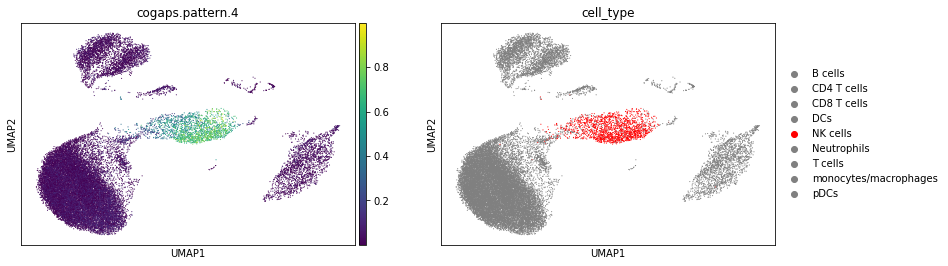

In [19]:
# only highlight the NK cells as identified by garnett, compare to pattern 4
nk_color = ['gray' for x in range(9)]
nk_color[4] = 'red'
sc.pl.umap(adata[adata.obs['cell_type'] != 'Unknown'], color=['cogaps.pattern.4', 'cell_type'], palette=nk_color)

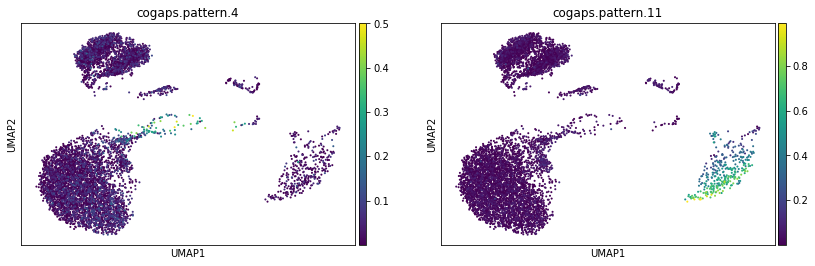

In [20]:
# plot a umap on the Neutrophils with only pattern 4 and 11 highlighted
sc.pl.umap(adata[adata.obs['cell_type'] == 'Neutrophils'], color=['cogaps.pattern.4', 'cogaps.pattern.11'])

### Exploring the Patterns
<a href=#Table-of-Contents>back to top</a>  

In most cases, the **CoGAPS** patterns will not so clearly identify groups such as the `NK cells` or the 10x channels. Part of a **CoGAPS** workflow is exploring the pattern space in order to determine the structure, or lack thereof, that it has learned from the original data. In this case, one interesting place to start would be pattern 14. It clearly is separating out a signal that was significant to the UMAP and TSNE algorithms, but that group of cells is not associated with any cell type or experimental condition. It is possible that it represents a phenotype that we haven't annotated yet, such a cell cycle (will be done in future versions of the notebook). It could also be that **garnett** was inaccurate in labeling cell types or our marker file was incomplete. In either case, it makes sense to examine this more closely.

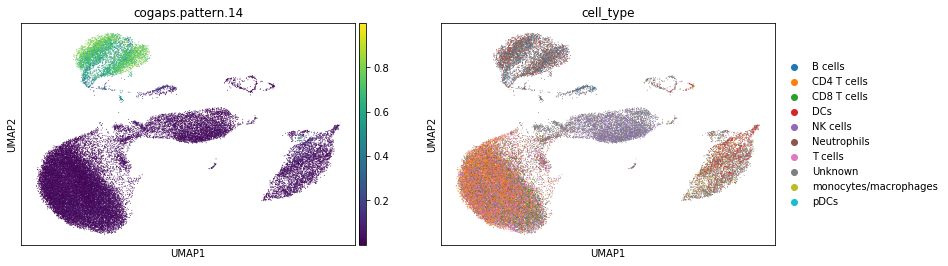

In [21]:
# plot all cell types against pattern 14
sc.pl.umap(adata[adata.obs['cell_type'] != 'Unkown'], color=['cogaps.pattern.14', 'cell_type'])

Clearly there is not agreement between any single **garnett** cell type and pattern 14. However, if we look at the pattern ranks for our marker genes we can see that pattern 14 is strongly associated with the marker genes for B cells. Here we plot the two patterns that have the highest marker ranks for B cells. It seems that **garnett** has some agreement in how to label `B cells`, but pattern 14 also has high weight in cells labeled `DCs` and `Neutrophils`. It is worth pointing out that these 3 cell types are the only ones to have any weight in pattern 14.

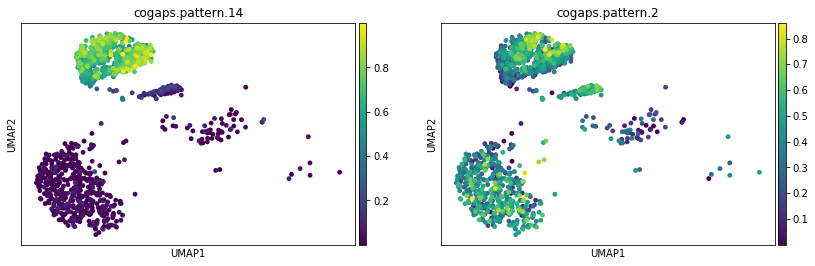

In [22]:
# plot patterns 14 and 2 on B cells identified by garnett
sc.pl.umap(adata[adata.obs['cell_type'] == 'B cells'], color=['cogaps.pattern.14', 'cogaps.pattern.2'])

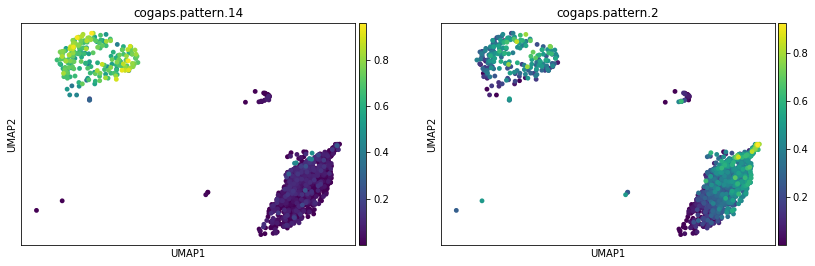

In [23]:
# plot patterns 14 and 2 on DCs identified by garnett
sc.pl.umap(adata[adata.obs['cell_type'] == 'DCs'], color=['cogaps.pattern.14', 'cogaps.pattern.2'])

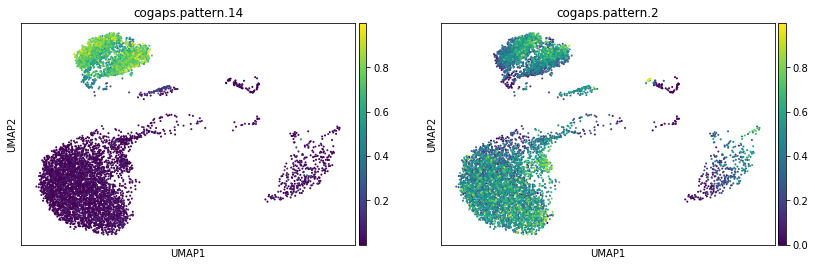

In [24]:
# plot patterns 14 and 2 on Neutrophils identified by garnett
sc.pl.umap(adata[adata.obs['cell_type'] == 'Neutrophils'], color=['cogaps.pattern.14', 'cogaps.pattern.2'])

In the next plot we show that all other cell types have no weight in pattern 14, however pattern 2 still has weight in seemingly all cell types. This suggests pattern 2 is a larger effect not specific to a cell type, but that pattern 14 is pulling out something specific to `B cells`, `DCs`, and `Neutrophils`.

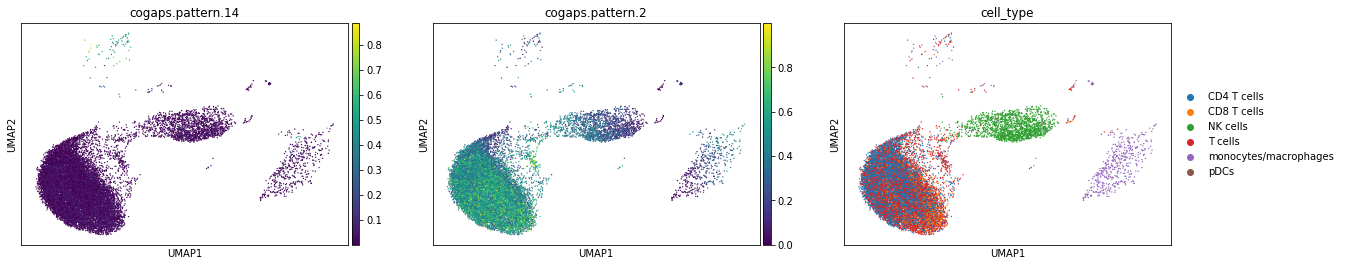

In [25]:
# this code allows us to easily subset to a list of cell types
cell_types = ['T cells', 'CD4 T cells', 'CD8 T cells', 'NK cells', 'pDCs', 'monocytes/macrophages']
index = adata.obs['cell_type'] == cell_types[0]
for ct in cell_types:
    index |= adata.obs['cell_type'] == ct
sc.pl.umap(adata[index], color=['cogaps.pattern.14', 'cogaps.pattern.2', 'cell_type'])    

The next three plots split the cell types up so there is no overlap in the UMAP. This allows us to see exactly which cell types UMAP can separate, and gives us some easy targets for finding **CoGAPS** patterns for. In future versions of the notebook we will do a complete accounting for all the patterns learned in **CoGAPS**. It will be interesting to see how well **CoGAPS** can separate the subtypes of T cells, something that is clearly not happening in the UMAP. We will also want to see if **CoGAPS** can separate the other cell types that overlap as well as any `Unknown` cell types, which make up roughly 1/3 of the total samples.

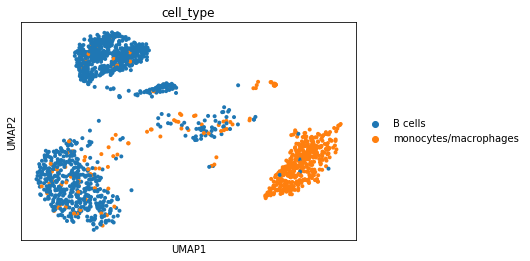

In [26]:
cell_types = ['monocytes/macrophages', 'B cells']
index = adata.obs['cell_type'] == cell_types[0]
for ct in cell_types:
    index |= adata.obs['cell_type'] == ct
sc.pl.umap(adata[index], color=['cell_type'])    

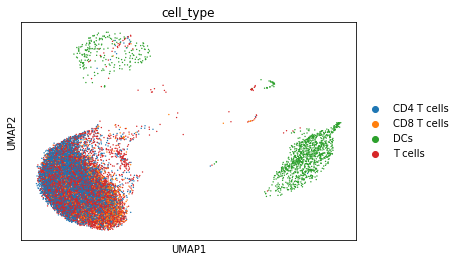

In [27]:
cell_types = ['DCs', 'T cells', 'CD4 T cells', 'CD8 T cells']
index = adata.obs['cell_type'] == cell_types[0]
for ct in cell_types:
    index |= adata.obs['cell_type'] == ct
sc.pl.umap(adata[index], color=['cell_type'])    

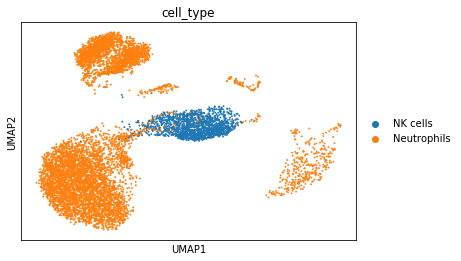

In [28]:
cell_types = ['Neutrophils', 'NK cells']
index = adata.obs['cell_type'] == cell_types[0]
for ct in cell_types:
    index |= adata.obs['cell_type'] == ct
sc.pl.umap(adata[index], color=['cell_type'])    

# References
<a href=#Table-of-Contents>back to top</a>  

1. Census of Immune Cells - Contributors: Bo Li, Monika S Kowalczyk, Danielle Dionne, Orr Ashenberg, Marcin Tabaka, Timothy Tickle, Jane Lee, Karthik Shekhar, Michal Slyper, Julia Waldman, Orit Rozenblatt-Rosen, Aviv Regev. Collaborating organisations: Broad Institute, Massachusetts Institute of Technology, Howard Hughes Medical Institute.

2. Fertig, E.J., et al. (2010). CoGAPS: an R/C++ package to identify patterns and biological process activity in transcriptomic data. Bioinformatics 26: 2792-2793.

3. Lun, A.T.L., et al. (2016). A step-by-step workflow for low-level analysis of single-cell RNA-seq data with Bioconductor. F1000Res., 5, 2122.

4. Pliner, H.A., et al. (2019). Supervised classification enables rapid annotation of cell atlases. bioRxiv

5. Stein-O'Brien, G.L. et al. (2017). PatternMarkers &amp; GWCoGAPS for novel data-driven biomarkers via whole transcriptome NMF. Bioinformatics 33(12): 1892-1894.

6. Stein-O'Brien, G.L. et al. (2018). Decomposing cell identity for transfer learning across cellular measurements, platforms, tissues, and species. BioRxiv

7. Stein-O'Brien, G.L. et al. (2018). Enter the Matrix: Factorization Uncovers Knowledge from Omics. Trends in Genetics, 34(10).

8. Wolf, A.F., et al. (2018). SCANPY: large-scale single-cell gene expression data analysis. Genome Biology. 19:15